Import Libraries

In [52]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report

Load Data

In [54]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

Data Shaping

In [56]:
x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.0
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

Print shape

In [58]:
print(f'Train Images Shape: {x_train.shape}')
print(f'Train Labels Shape: {y_train.shape}')
print(f'Test Images Shape: {x_test.shape}')
print(f'Test Labels Shape: {y_test.shape}')

Train Images Shape: (60000, 784)
Train Labels Shape: (60000,)
Test Images Shape: (10000, 784)
Test Labels Shape: (10000,)


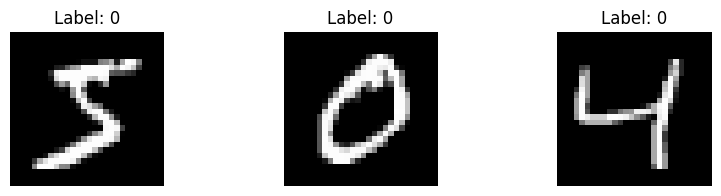

In [59]:
def visualize_images(images, labels, num_images=5):
    images = images.reshape((-1, 28, 28))
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title("Label: {}".format(np.argmax(labels[i])))
        plt.axis('off')
    plt.show()

visualize_images(x_train, y_train, num_images=3)

In [60]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, activation_functions, dropout_rate=0.0, regularization=None, lambd=0.0):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.activation_functions = activation_functions
        self.dropout_rate = dropout_rate
        self.regularization = regularization
        self.lambd = lambd

        self.layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layer = {
                'weights': np.random.randn(hidden_size, prev_size) / np.sqrt(prev_size),
                'biases': np.random.randn(hidden_size, 1) / np.sqrt(hidden_size)
            }
            self.layers.append(layer)
            prev_size = hidden_size
        self.output_layer = {
            'weights': np.random.randn(output_size, prev_size) / np.sqrt(prev_size),
            'biases': np.random.randn(output_size, 1) / np.sqrt(prev_size)
        }

    def activation_function(self, Z, func_type='ReLU', derivative=False):
        if func_type == 'ReLU':
            if derivative:
                return (Z > 0).astype(float)
            return np.maximum(0, Z)
        elif func_type == 'Sigmoid':
            sig = 1 / (1 + np.exp(-Z))
            if derivative:
                return sig * (1 - sig)
            return sig
        elif func_type == 'tanh':
            tanh = np.tanh(Z)
            if derivative:
                return 1 - np.square(tanh)
            return tanh
        else:
            raise ValueError('Unsupported activation function type.')

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))
        return exp_z / exp_z.sum(axis=0, keepdims=True)

    def cross_entropy_loss(self, predictions, labels):
        return -np.log(predictions[labels])

    def forward_pass(self, x, y, apply_dropout=False):
        activations = [x.reshape(-1, 1)]
        dropout_masks = []
        for layer, func in zip(self.layers, self.activation_functions):
            Z = np.dot(layer['weights'], activations[-1]) + layer['biases']
            A = self.activation_function(Z, func)
            if apply_dropout and self.dropout_rate > 0:
                dropout_mask = np.random.binomial(1, 1 - self.dropout_rate, size=A.shape) / (1 - self.dropout_rate)
                A *= dropout_mask
                dropout_masks.append(dropout_mask)
            activations.append(A)
        Z = np.dot(self.output_layer['weights'], activations[-1]) + self.output_layer['biases']
        predictions = self.softmax(Z).squeeze()
        error = self.cross_entropy_loss(predictions, y)
        return {'activations': activations, 'predictions': predictions, 'error': error, 'dropout_masks': dropout_masks}

    def back_propagation(self, x, y, forward_results):
        E = np.zeros(self.output_size).reshape((1, self.output_size))
        E[0, y] = 1
        dU = -(E - forward_results['predictions']).reshape((self.output_size, 1))
        dC = np.dot(dU, forward_results['activations'][-1].T)
        delta = np.dot(self.output_layer['weights'].T, dU)
        deltas = [delta]
        grads = [{'weights': dC, 'biases': dU}]

        for i in range(len(self.layers) - 1, -1, -1):
            activation_func = self.activation_functions[i]
            A_prev = forward_results['activations'][i + 1]
            dA = deltas[-1]
            if self.dropout_rate > 0 and i < len(forward_results['dropout_masks']):
                dA *= forward_results['dropout_masks'][i]
            dZ = dA * self.activation_function(A_prev, activation_func, derivative=True)
            dW = np.dot(dZ, forward_results['activations'][i].T)
            db = dZ
            delta = np.dot(self.layers[i]['weights'].T, dZ)
            deltas.append(delta)
            grads.append({'weights': dW, 'biases': db})

        return grads[::-1]

    def update_parameters(self, grads, learning_rate):
        for i, layer in enumerate(self.layers):
            if self.regularization == 'L2':
                layer['weights'] -= learning_rate * (grads[i]['weights'] + self.lambd * layer['weights'])
            elif self.regularization == 'L1':
                layer['weights'] -= learning_rate * (grads[i]['weights'] + self.lambd * np.sign(layer['weights']))
            else:
                layer['weights'] -= learning_rate * grads[i]['weights']
            layer['biases'] -= learning_rate * grads[i]['biases']
        self.output_layer['weights'] -= learning_rate * grads[-1]['weights']
        self.output_layer['biases'] -= learning_rate * grads[-1]['biases']

    def compute_loss(self, X, Y):
        total_loss = 0
        for x, y in zip(X, Y):
            total_loss += self.forward_pass(x, y)['error']
        if self.regularization == 'L2':
            total_loss += self.lambd / 2 * sum(np.sum(layer['weights'] ** 2) for layer in self.layers)
        elif self.regularization == 'L1':
            total_loss += self.lambd * sum(np.sum(np.abs(layer['weights'])) for layer in self.layers)
        return total_loss / len(Y)

    def train(self, X_train, Y_train, X_test, y_test, num_iterations=1000, learning_rate=0.5, batch_size=32, optimizer=None):
        training_losses = []
        test_accuracies = []
        training_accuracies = []
        testing_losses = []
        initial_lr = learning_rate

        for i in range(num_iterations):
            batch_indices = np.random.choice(len(X_train), batch_size)
            X_batch = X_train[batch_indices]
            Y_batch = Y_train[batch_indices]

            for x, y in zip(X_batch, Y_batch):
                forward_results = self.forward_pass(x, y, apply_dropout=True)
                grads = self.back_propagation(x, y, forward_results)
                self.update_parameters(grads, learning_rate)

            if i % 100 == 0:
                train_loss = self.compute_loss(X_train, Y_train)
                train_accuracy, _ = self.evaluate(X_train, Y_train)
                test_accuracy, _ = self.evaluate(X_test, y_test)
                test_loss = self.compute_loss(X_test, y_test)

                training_losses.append(train_loss)
                test_accuracies.append(test_accuracy)
                training_accuracies.append(train_accuracy)
                testing_losses.append(test_loss)

                print(f'Iteration {i}: Training Loss = {train_loss:.4f}, Training Accuracy = {train_accuracy:.4f}, Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}')

                # Learning rate decay
                learning_rate = initial_lr * (0.95 ** (i // 1000))

        return training_losses, test_accuracies, training_accuracies, testing_losses

    def evaluate(self, X, Y):
        correct_predictions = 0
        predictions = []
        for x, y in zip(X, Y):
            forward_results = self.forward_pass(x, y)
            prediction = np.argmax(forward_results['predictions'])
            predictions.append(prediction)
            if prediction == y:
                correct_predictions += 1
        accuracy = correct_predictions / len(Y)
        return accuracy, predictions

In [61]:
num_inputs = 28 * 28
num_outputs = 10
hidden_sizes = [300]
activation_functions = ['ReLU']
num_iterations = 5000
learning_rate = 0.01
dropout_rate = 0.5
regularization = 'L2'
lambd = 0.01

In [ ]:
nn_model = NeuralNetwork(num_inputs, hidden_sizes, num_outputs, activation_functions, dropout_rate, regularization, lambd)
training_losses, test_accuracies, training_accuracies, testing_losses = nn_model.train(x_train, y_train, x_test, y_test, num_iterations, learning_rate)

Iteration 0: Training Loss = 2.1920, Training Accuracy = 0.2815, Test Loss = 2.1944, Test Accuracy = 0.2786
Iteration 100: Training Loss = 0.4455, Training Accuracy = 0.8749, Test Loss = 0.4256, Test Accuracy = 0.8845
Iteration 200: Training Loss = 0.3799, Training Accuracy = 0.8832, Test Loss = 0.3643, Test Accuracy = 0.8934
Iteration 300: Training Loss = 0.3542, Training Accuracy = 0.8960, Test Loss = 0.3388, Test Accuracy = 0.9027
Iteration 400: Training Loss = 0.3536, Training Accuracy = 0.8938, Test Loss = 0.3562, Test Accuracy = 0.8913
Iteration 500: Training Loss = 0.3028, Training Accuracy = 0.9073, Test Loss = 0.2889, Test Accuracy = 0.9120
Iteration 600: Training Loss = 0.2982, Training Accuracy = 0.9090, Test Loss = 0.2857, Test Accuracy = 0.9154
Iteration 700: Training Loss = 0.2570, Training Accuracy = 0.9247, Test Loss = 0.2447, Test Accuracy = 0.9249
Iteration 800: Training Loss = 0.2821, Training Accuracy = 0.9112, Test Loss = 0.2687, Test Accuracy = 0.9169
Iteration 90

In [ ]:
test_accuracy, test_predictions = nn_model.evaluate(x_test, y_test)

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(testing_losses, label='Test Loss')
plt.xlabel('Iterations (x100)')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Iterations (x100)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()